# AIDM7330 Basic Programming for Data Science
# Tutorial: Scraping multiple pages
In this tutorial we’ll learn to scrape multiple web pages with Python using `BeautifulSoup` and `requests`. We will be scraping hundreds of movies from [imdb](https://www.imdb.com/?ref_=nv_home) and store data using the `Pandas` library.

In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from time import sleep
from time import time
from random import randint

## Scraping single page
If you go on IMDB’s advanced search [page](https://www.imdb.com/search/), you can browse movies by year:
<img src="../figures/home.png" alt="drawing" width="550"/>
<img src="../figures/search.png" alt="drawing" width="550"/>
<img src="../figures/search-year.png" alt="drawing" width="550"/>
Let’s choose "feature film", browse by year 2021, sort the movies on the number of votes, we'll arrive [this page](https://www.imdb.com/search/title/?title_type=feature&release_date=2021-01-01,2021-12-31&sort=num_votes,desc)  
- A feature film, feature-length film, or theatrical film is a film with a running time long enough to be considered the principal or sole film to fill a program. (wiki)

### <span style="color:DARKTURQUOISE">Note</span>  
As a side note, if you run the code from a country where English is not the main language, it’s very likely that you’ll get some of the movie names translated into the main language of that country.

Most likely, this happens because the server infers your location from your IP address. Even if you are located in a country where English is the main language, you may still get translated content. This may happen if you’re using a VPN while you’re making the `GET` requests.

If you run into this issue, pass the following values to the `headers` parameter of the `get()` function:

In [ ]:
headers = {"Accept-Language": "en-US, en;q=0.5"}
url = 'https://www.imdb.com/search/title/?title_type=feature&release_date=2021-01-01,2021-12-31&sort=num_votes,desc'
page = requests.get(url, headers = headers)
print(page.status_code)

200


This will communicate the server something like “I want the linguistic content in American English (en-US). If en-US is not available, then other types of English (en) would be fine too (but not as much as en-US).”. The `q` parameter indicates the degree to which we prefer a certain language. If not specified, then the values is set to `1` by default, like in the case of en-US. You can read more about this [here](https://www.w3.org/Protocols/rfc2616/rfc2616-sec14.html#sec14.4).


### Extract movie information
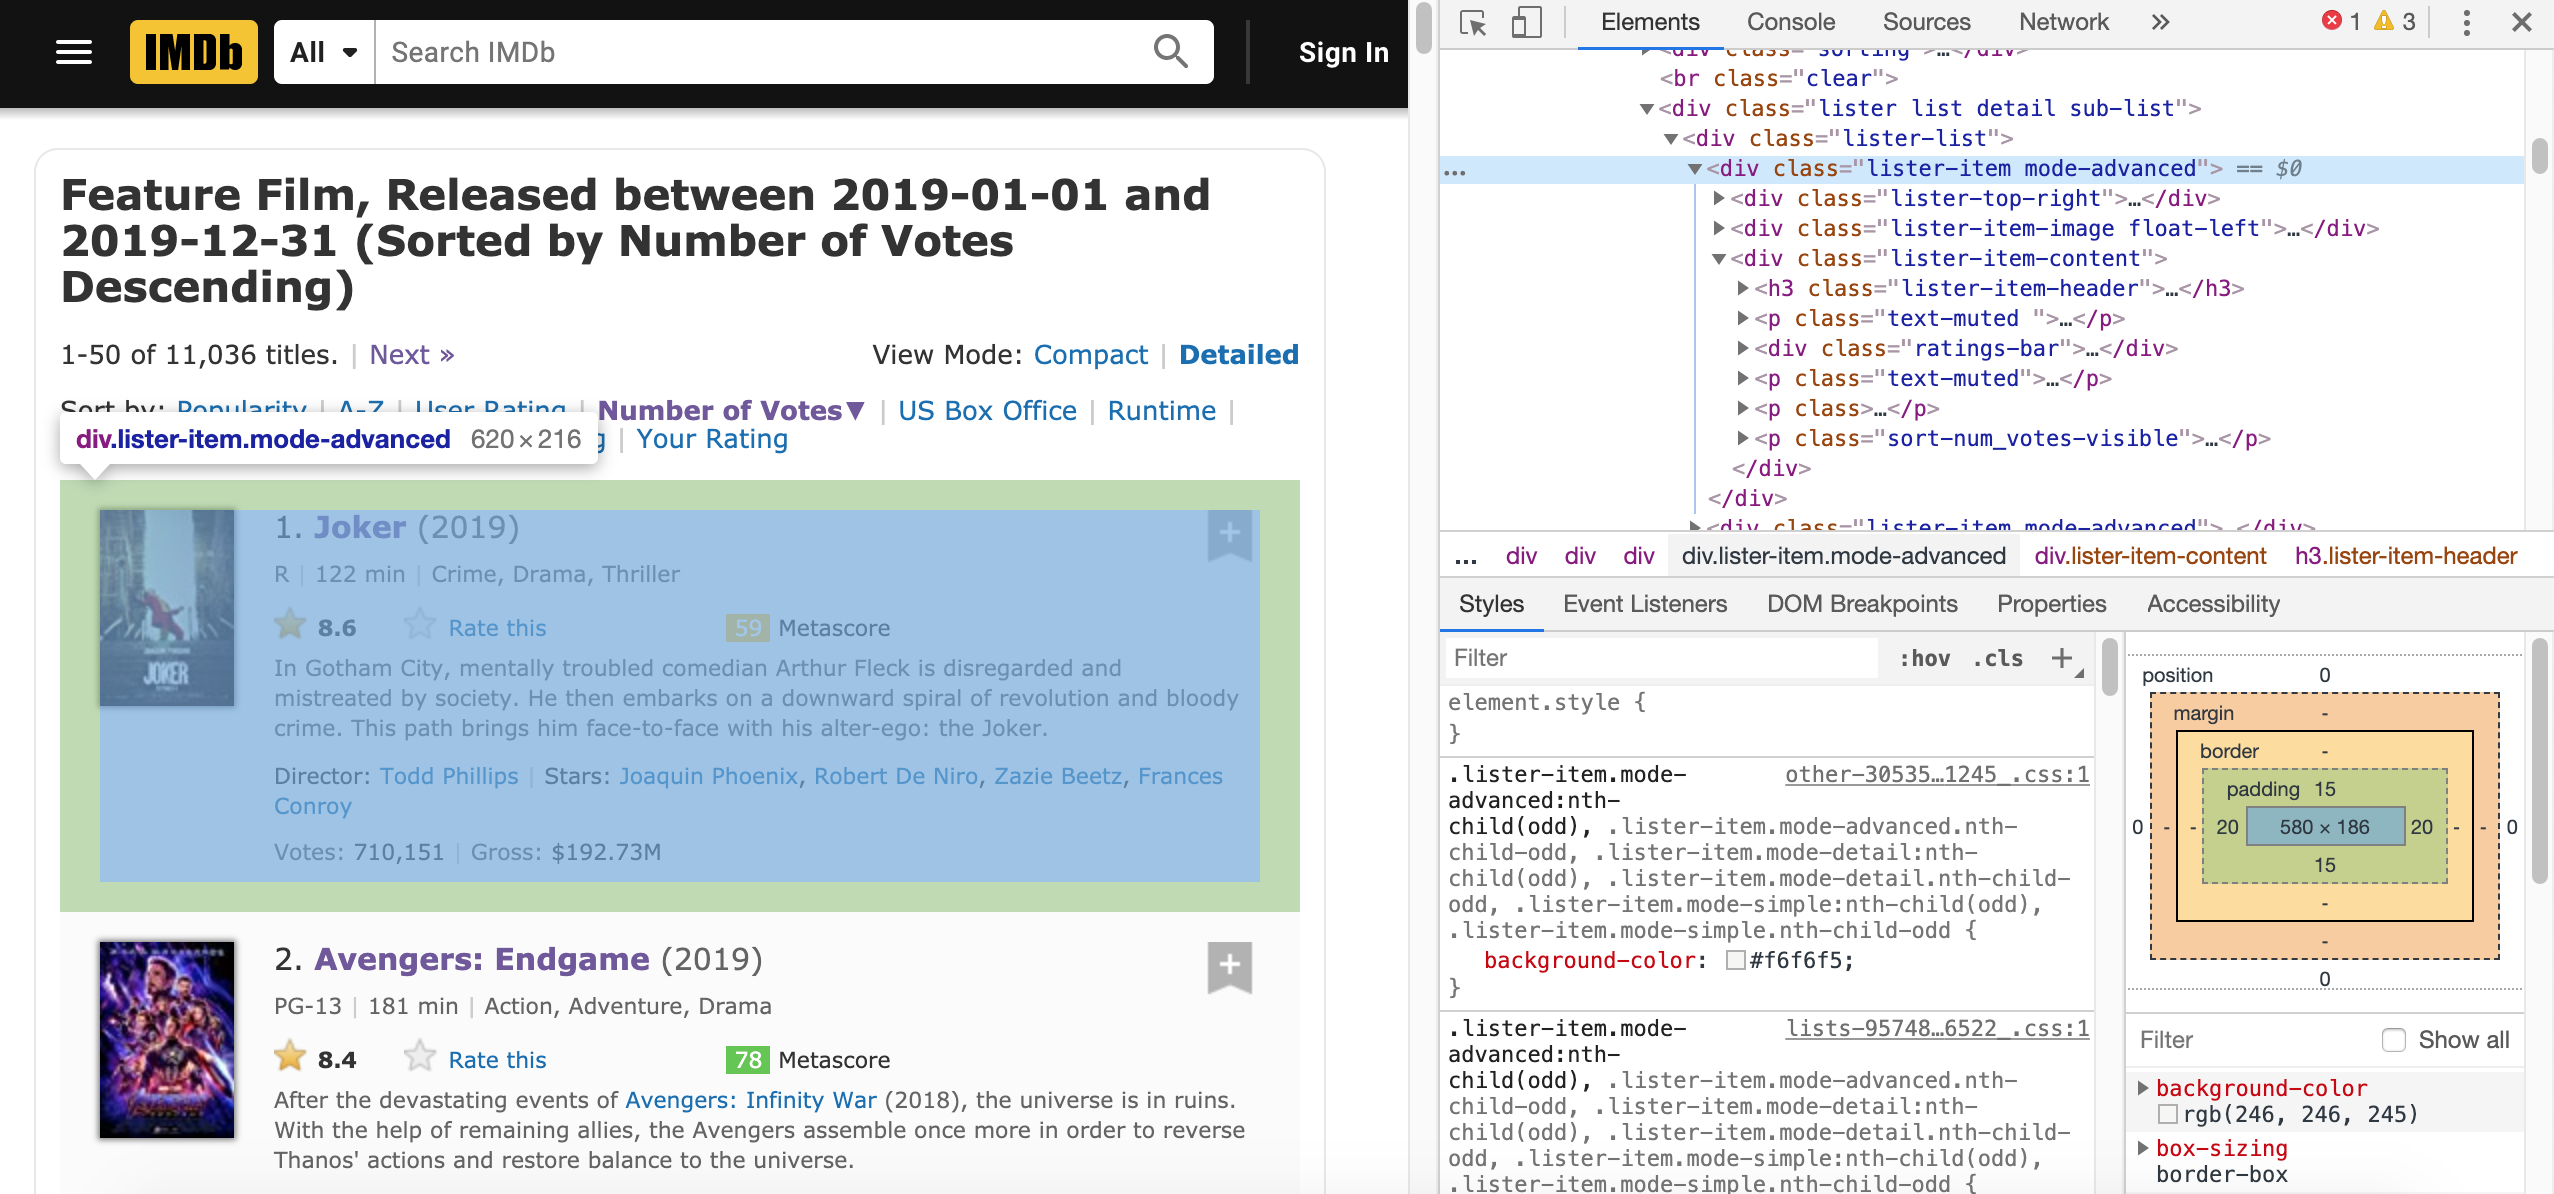

In [ ]:
html_soup = BeautifulSoup(page.content, 'html.parser')
movie_containers = html_soup.find_all('div', class_ = 'lister-item mode-advanced')
print(len(movie_containers))

50


Now we’ll extract, by turn, each item of interest for each container:

- The name of the movie.
- The year of release.
- The IMDB rating.
- The number of votes.

### The number of votes
The number of votes is contained within a `<span>` tag. Its distinctive mark is a `name` attribute with the value `nv`.
<img src="../figures/vote.png" alt="drawing" width="500"/>

The `name` attribute is different from the `class` attribute. Using BeautifulSoup we can access elements by any attribute. The `find()` and `find_all()` functions have a parameter named `attrs`. To this we can pass in the attributes and values we are searching for as a dictionary. You can read more about this [here](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#the-keyword-arguments)

In [ ]:
container = movie_containers[0]
vote = container.find('span', attrs={'name':'nv'})['data-value']
vote

'839884'

We could use `.get_text()` notation to access the `<span>` tag’s content. It would be better though if we accessed the value of the data-value attribute. This way we can convert the extracted datapoint to an `int` without having to strip a comma.

You can treat a Tag object just like a `dictionary`. The HTML attributes are the dictionary’s keys. The values of the HTML attributes are the values of the dictionary’s keys. This is how we can access the value of the `data-value` attribute.

#### Using of CSS Selector

We extract the movie title by using CSS selectors [(more about CSS selectors)](https://www.htmldog.com/guides/css/intermediate/classid/).
The `select` method allows you to **find tags beneath other tags**:

In [ ]:
name = container.select('.lister-item-header a')[0].get_text()
print(name)

Spider-Man: No Way Home


### Combine everything
In the next code block we:

- Declare some list variables to have something to store the extracted data in.
- Loop through each container in movie_containers (the variable which contains all the 50 movie containers).
- Extract the information of each moive container.

In [ ]:
headers = {"Accept-Language": "en-US, en;q=0.5"}
url = 'https://www.imdb.com/search/title/?title_type=feature&release_date=2021-01-01,2021-12-31&sort=num_votes,desc'
page = requests.get(url, headers = headers)
print(page.status_code)

html_soup = BeautifulSoup(page.content, 'html.parser')
movie_containers = html_soup.find_all('div', class_ = 'lister-item mode-advanced')

# Lists to store the scraped data in
names = []
years = []
imdb_ratings = []
votes = []


# Extract data from individual movie container
for container in movie_containers:
    # The name
    name = container.select('.lister-item-header a')[0].get_text()
    names.append(name)
    # The year
    year = container.find('span', class_ = 'lister-item-year').get_text()
    years.append(year)
    # The IMDB rating
    imdb = float(container.find('strong').get_text())
    imdb_ratings.append(imdb)
    # The number of votes
    vote = container.find('span', attrs={'name':'nv'})['data-value']
    votes.append(int(vote))

200


Let's store the collected data into a `dataframe`.

In [ ]:
test_df = pd.DataFrame({'movie': names,
'year': years,
'rating': imdb_ratings,
'votes': votes
})
print(test_df.info())
test_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   movie   50 non-null     object 
 1   year    50 non-null     object 
 2   rating  50 non-null     float64
 3   votes   50 non-null     int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 1.7+ KB
None


,movie,year,rating,votes
0,Spider-Man: No Way Home,(2021),8.2,839884
1,Dune,(2021),8.0,723598
2,Don't Look Up,(2021),7.2,575164
3,No Time to Die,(2021),7.3,431436
4,Zack Snyder's Justice League,(2021),7.9,426293
5,Shang-Chi and the Legend of the Ten Rings,(2021),7.4,418456
6,Black Widow,(2021),6.7,410868
7,Free Guy,(2021),7.1,405873
8,The Suicide Squad,(2021),7.2,389918
9,Eternals,(2021),6.3,371904


## Scraping multiple pages
Scraping multiple pages is a bit more challenging. We’ll build upon our one-page script by doing more things:

1. Making all the requests we want from within the loop.
1. Controlling the loop’s rate to avoid bombarding the server with requests.

We’ll scrape the first 2 pages of year 2020. Each page has 50 movies, so we’ll scrape data for 100 movies.

### Identifying the URL structure
Our challenge now is to make sure we understand the logic of the URL as the pages we want to scrape change. If we can’t understand this logic enough so we can implement it into code, then we’ll reach a dead end.  
Let’s browse by year 2020, sort the movies by number of votes, then switch to the next page. We’ll arrive at this [web page](https://www.imdb.com/search/title/?title_type=feature&release_date=2021-01-01,2021-12-31&sort=num_votes,desc&start=51&ref_=adv_nxt), which has this URL:  

https://www.imdb.com/search/title/?title_type=feature&release_date=2021-01-01,2021-12-31&sort=num_votes,desc&start=51&ref_=adv_nxt  


In the URL above, you can see that the URL has several parameters after the question mark:

- release_date — Shows only the movies released in a specific year.
- sort — Sorts the movies on the page. sort=num_votes,desc translates to sort by number of votes in a descending order.
- start — Specifies the number of first movie item in current page.
- ref_ — Takes us to the the next or the previous page. The reference is the page we are currently on. adv_nxt and adv_prv are two possible values. They translate to advance to the next page, and advance to the previous page, respectively.

If you change `start` value to 1, the URL become:\
https://www.imdb.com/search/title/?title_type=feature&release_date=2021-01-01,2021-12-31&sort=num_votes,desc&start=1&ref_=adv_nxt which will navigate to the first page.

If you navigate through those pages and observe the URL, you will notice that only the values of the parameters change. This means we can write a script to match the logic of the changes and make far fewer requests to scrape our data.

### Changing the URL’s parameters
As we are making the requests, we’ll only have to vary the values of `start` parameters of the URL. Let’s prepare the values we’ll need for the forthcoming loop.

In [ ]:
start_nums = []
for i in range(0, 5):
    print(i)
    start_nums.append(str(i*50+1))
start_nums

0
1
2
3
4


['1', '51', '101', '151', '201']

### Controlling the crawl-rate
Controlling the rate of crawling is beneficial for us, and for the website we are scraping. If we avoid hammering the server with tens of requests per second, then we are much less likely to get our IP address banned. We also avoid disrupting the activity of the website we scrape by allowing the server to respond to other users’ requests too.

We’ll control the loop’s rate by using the `sleep()` function from Python’s `time` module. `sleep()` will **pause** the execution of the loop for a specified amount of seconds.

To mimic human behavior, we’ll vary the amount of waiting time between requests by using the `randint()` function from the Python’s random module. `randint()` randomly generates integers within a specified interval.

In [ ]:
from time import sleep
from time import time
from random import randint

# Pause the loop
sleep(randint(3,10))

### Piecing everything together
Now let’s piece together everything we’ve done so far

In [ ]:
# headers = {"Accept-Language": "en-US, en;q=0.5"}

# Redeclaring the lists to store data in
names = []
years = []
imdb_ratings = []
votes = []

start_nums = []
for i in range(0, 2):
    start_nums.append(str(i*50+1))

# For every page in the interval
for start_num in start_nums:

    # Make a get request
    url = 'https://www.imdb.com/search/title/?title_type=feature&release_date=2021-01-01,2021-12-31&sort=num_votes,desc&start='\
        + start_num + '&ref_=adv_nxt'
    print(url)
    response = requests.get(url, headers = headers)

    # Pause the loop
    sleep(randint(3,6))


    # Parse the content of the request with BeautifulSoup
    html_soup = BeautifulSoup(response.content, 'html.parser')

    # Select all the 50 movie containers from a single page
    movie_containers = html_soup.find_all('div', class_ = 'lister-item mode-advanced')

    # For every movie of these 50
    # Extract data from individual movie container
    for container in movie_containers:
        # The name
        name = container.select('.lister-item-header a')[0].get_text()
        names.append(name)
        # The year
        year = container.find('span', class_ = 'lister-item-year').get_text()
        years.append(year)
        # The IMDB rating
        imdb = float(container.find('strong').get_text())
        imdb_ratings.append(imdb)
        # The number of votes
        vote = container.find('span', attrs={'name':'nv'})['data-value']
        votes.append(int(vote))


movie_ratings = pd.DataFrame({'movie': names,
'year': years,
'imdb': imdb_ratings,
'votes': votes
})
print(movie_ratings.info())
movie_ratings.head(10)

https://www.imdb.com/search/title/?title_type=feature&release_date=2021-01-01,2021-12-31&sort=num_votes,desc&start=1&ref_=adv_nxt
https://www.imdb.com/search/title/?title_type=feature&release_date=2021-01-01,2021-12-31&sort=num_votes,desc&start=51&ref_=adv_nxt
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   movie   100 non-null    object 
 1   year    100 non-null    object 
 2   imdb    100 non-null    float64
 3   votes   100 non-null    int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ KB
None


,movie,year,imdb,votes
0,Spider-Man: No Way Home,(2021),8.2,839884
1,Dune,(2021),8.0,723598
2,Don't Look Up,(2021),7.2,575164
3,No Time to Die,(2021),7.3,431436
4,Zack Snyder's Justice League,(2021),7.9,426293
5,Shang-Chi and the Legend of the Ten Rings,(2021),7.4,418456
6,Black Widow,(2021),6.7,410868
7,Free Guy,(2021),7.1,405873
8,The Suicide Squad,(2021),7.2,389918
9,Eternals,(2021),6.3,371904


In [ ]:
movie_ratings.tail(50)

## Scraping single movie pages
Next, we'll explore the single move pages to extract the writers information of each movie.
### Find the link to the movie
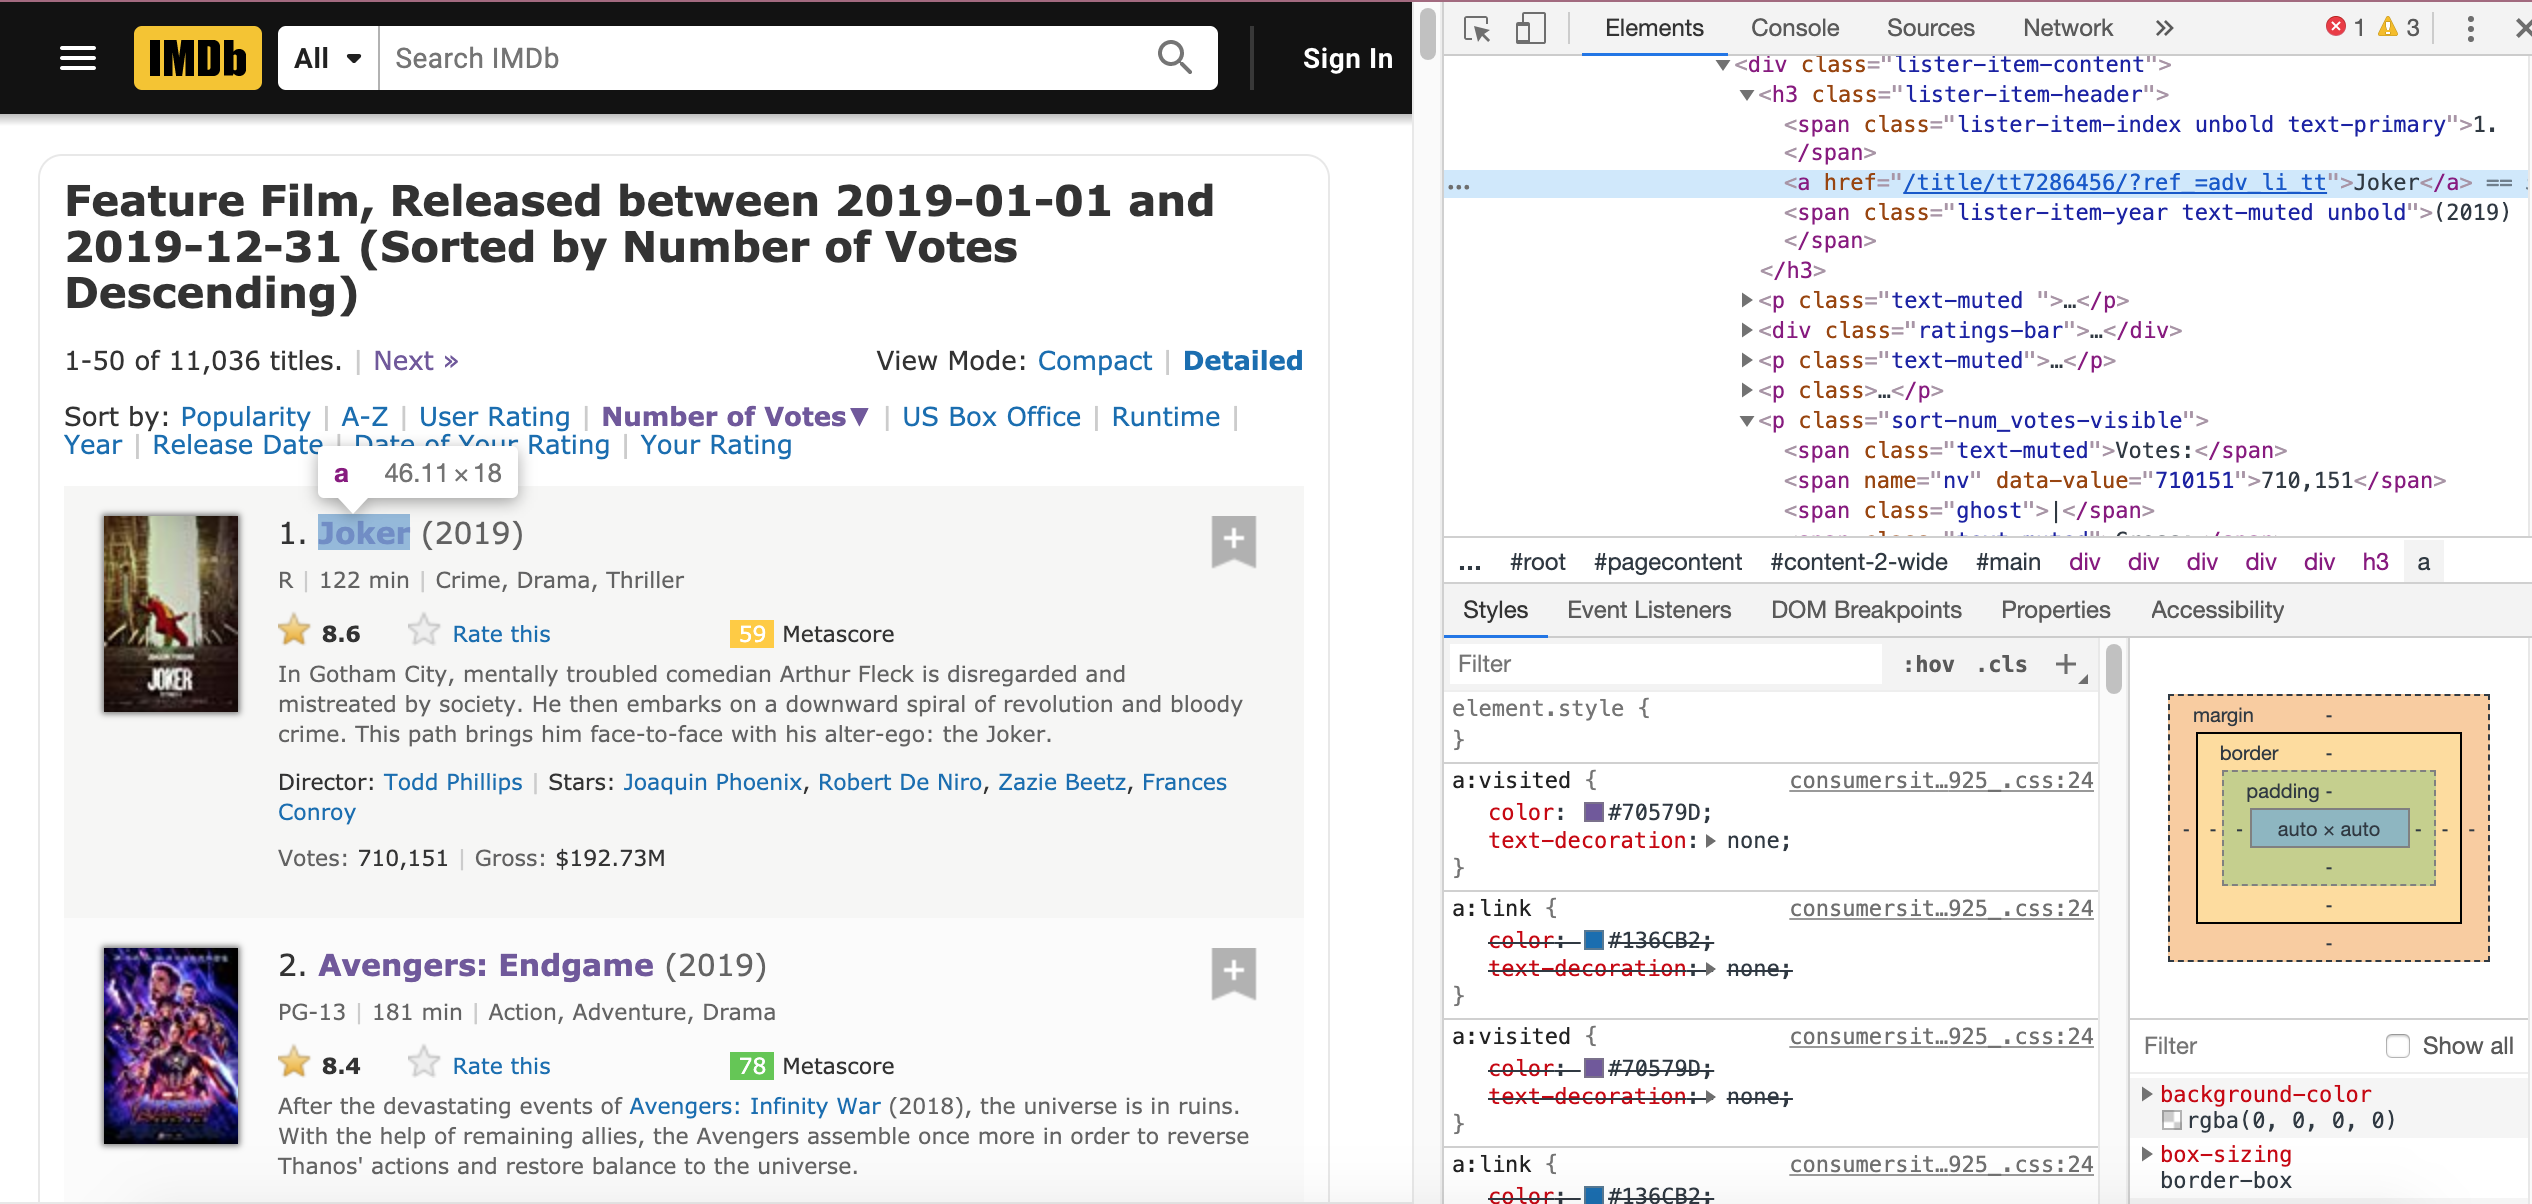

The link to the movie is " https://www.imdb.com/title/tt12361974/?ref_=adv_li_tt ". Thus, we concatenate the string “https://www.imdb.com" with "/title/tt12361974/?ref_=adv_li_tt" to get the URL of the first movie


In [ ]:
domain = 'https://www.imdb.com'
sub_url = container.select('.lister-item-header a')[0]['href']
print('sub url:', sub_url)
# url of movie page
movie_url = domain + sub_url
print('movie url:', movie_url)
movie_html = requests.get(movie_url, headers = headers)

sub url: /title/tt10280296/
movie url: https://www.imdb.com/title/tt10280296/


### Extract information & store to dataframe
Now, let's extract user reviews and critic reviews information from each single movie page.

In [ ]:
headers = {"Accept-Language": "en-US, en;q=0.5"}
url = 'https://www.imdb.com/search/title/?title_type=feature&release_date=2021-01-01,2021-12-31&sort=num_votes,desc&start=1&ref_=adv_nxt'
page = requests.get(url, headers = headers)
print(page.status_code)

html_soup = BeautifulSoup(page.content, 'html.parser')
movie_containers = html_soup.find_all('div', class_ = 'lister-item mode-advanced')

# initialize
user_reviews_list = []
critic_reviews_list = []
domain = 'https://www.imdb.com'
for container in movie_containers:
    sub_url = container.select('.lister-item-header a')[0]['href']
    # url of movie page
    movie_url = domain + sub_url
    movie_html = requests.get(movie_url, headers = headers)
    # Pause the loop
    sleep(randint(3,6))

    # extract reviews information
    movie_soup = BeautifulSoup(movie_html.content, 'html.parser') # parser of individual movie page
    review_li = movie_soup.find_all('li', class_ = 'ipc-inline-list__item sc-124be030-1 ghlYSH')
    if len(review_li) > 0:
      user_reviews = review_li[0].find('span', class_ = 'score').get_text()
      user_reviews_list.append(user_reviews)
      critic_reviews = review_li[1].find('span', class_ = 'score').get_text()
      critic_reviews_list.append(critic_reviews)
    else:
      print('No reviews found, please check')

review_df = pd.DataFrame({'user reviews': user_reviews_list, 'critic reviews': critic_reviews_list})
print(review_df.info())
review_df

200
No reviews found, please check
No reviews found, please check
No reviews found, please check
No reviews found, please check
No reviews found, please check
No reviews found, please check
No reviews found, please check
No reviews found, please check
No reviews found, please check
No reviews found, please check
No reviews found, please check
No reviews found, please check
No reviews found, please check
No reviews found, please check
No reviews found, please check
No reviews found, please check
No reviews found, please check
No reviews found, please check


KeyboardInterrupt: ignored

### Concatenate dataframes
Finally, let's combine the writers' information with previous collected information.

We use `pd.concat()` function to achieve this.  
`axis` : {0, 1, …}, default 0. The axis to concatenate along.
- axis=0: concatenate on rows;
- axis=1: concatenate on columns

[more about concat on dataframe](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html)

In [ ]:
result = pd.concat([test_df, review_df], axis=1)
result

## Save data to file

First we need to connect to your Google Drive account.

For security reasons, you will be requested to grant permission to Google Colab to access your Google Drive. Please allow the operation by selecting the correct account where you store your Colab Notebooks.

In [ ]:
from google.colab import drive
drivePath = '/content/drive' #please do not change
drive.mount(drivePath)

Now we can select the correct directory in your Google drive.

In [ ]:
#path to data directory
dataPath = drivePath + '/MyDrive/Colab Notebooks/data' + "/"

We will also check if the directory is present, creating a new one if needed.

In [ ]:
import os, pathlib
if not(os.path.exists(dataPath)):
  # os.mkdir(dataPath) # Creates only the last directory if missing. Rises error if it exists
  path = pathlib.Path(dataPath)
  path.mkdir(parents=True, exist_ok=True) # Can create the folders in the path if missing. No error if path exists
  print('Path has been created')
else:
  print('The data path you selected already exists')

In [ ]:
result.to_csv(dataPath + 'imdb.csv')

- The codes in this notebook are modified from various sources. All codes are for educational purposes only and released under the CC1.0.